In [51]:
using Random
using Distributions
using LinearAlgebra
using ForwardDiff
include("../Inversion/Plot.jl")
include("../Inversion/GMGD.jl")

visualization_2d (generic function with 1 method)

## Gaussian mixture

This is not an inverse problem!

$$
e^{-\Phi_r(\theta)} \propto \sum_i w_i \mathcal{N}(\theta; m_i, C_i) \\
\Phi_r(\theta) = - \log\Bigl( \sum_i w_i \mathcal{N}(\theta; m_i, C_i) \Bigr)
$$



In [36]:
function Gaussian_mixture(x, args)
    x_w, x_mean, inv_sqrt_x_cov = args
    # C = L L.T
    # C^-1 = L^-TL^-1
    N_x = size(x_mean, 2)
    ρ = 0
    for im = 1:length(x_w)
        ρ += x_w[im]*exp(-0.5*(x-x_mean[im,:])'*(inv_sqrt_x_cov[im]'*inv_sqrt_x_cov[im]*(x-x_mean[im,:])))/det(inv_sqrt_x_cov[im])
    end
    return log(ρ) - N_x/2*log(2*π)
end



function Gaussian_mixture_V(θ, args)
    return -Gaussian_mixture(θ, args), 
           -ForwardDiff.gradient(x -> Gaussian_mixture(x, args), θ), 
           -ForwardDiff.hessian(x -> Gaussian_mixture(x, args), θ)
end



Gaussian_mixture_V (generic function with 1 method)

[ Info: ("iter = ", 100, " / ", 1000)
[ Info: ("iter = ", 200, " / ", 1000)
[ Info: ("iter = ", 300, " / ", 1000)
[ Info: ("iter = ", 400, " / ", 1000)
[ Info: ("iter = ", 500, " / ", 1000)
[ Info: ("iter = ", 600, " / ", 1000)
[ Info: ("iter = ", 700, " / ", 1000)
[ Info: ("iter = ", 800, " / ", 1000)
[ Info: ("iter = ", 900, " / ", 1000)
[ Info: ("iter = ", 1000, " / ", 1000)
[ Info: ("iter = ", 100, " / ", 1000)
[ Info: ("iter = ", 200, " / ", 1000)
[ Info: ("iter = ", 300, " / ", 1000)
[ Info: ("iter = ", 400, " / ", 1000)
[ Info: ("iter = ", 500, " / ", 1000)
[ Info: ("iter = ", 600, " / ", 1000)
[ Info: ("iter = ", 700, " / ", 1000)
[ Info: ("iter = ", 800, " / ", 1000)
[ Info: ("iter = ", 900, " / ", 1000)
[ Info: ("iter = ", 1000, " / ", 1000)
[ Info: ("iter = ", 100, " / ", 1000)
[ Info: ("iter = ", 200, " / ", 1000)
[ Info: ("iter = ", 300, " / ", 1000)
[ Info: ("iter = ", 400, " / ", 1000)
[ Info: ("iter = ", 500, " / ", 1000)
[ Info: ("iter = ", 600, " / ", 1000)
[ Info: ("

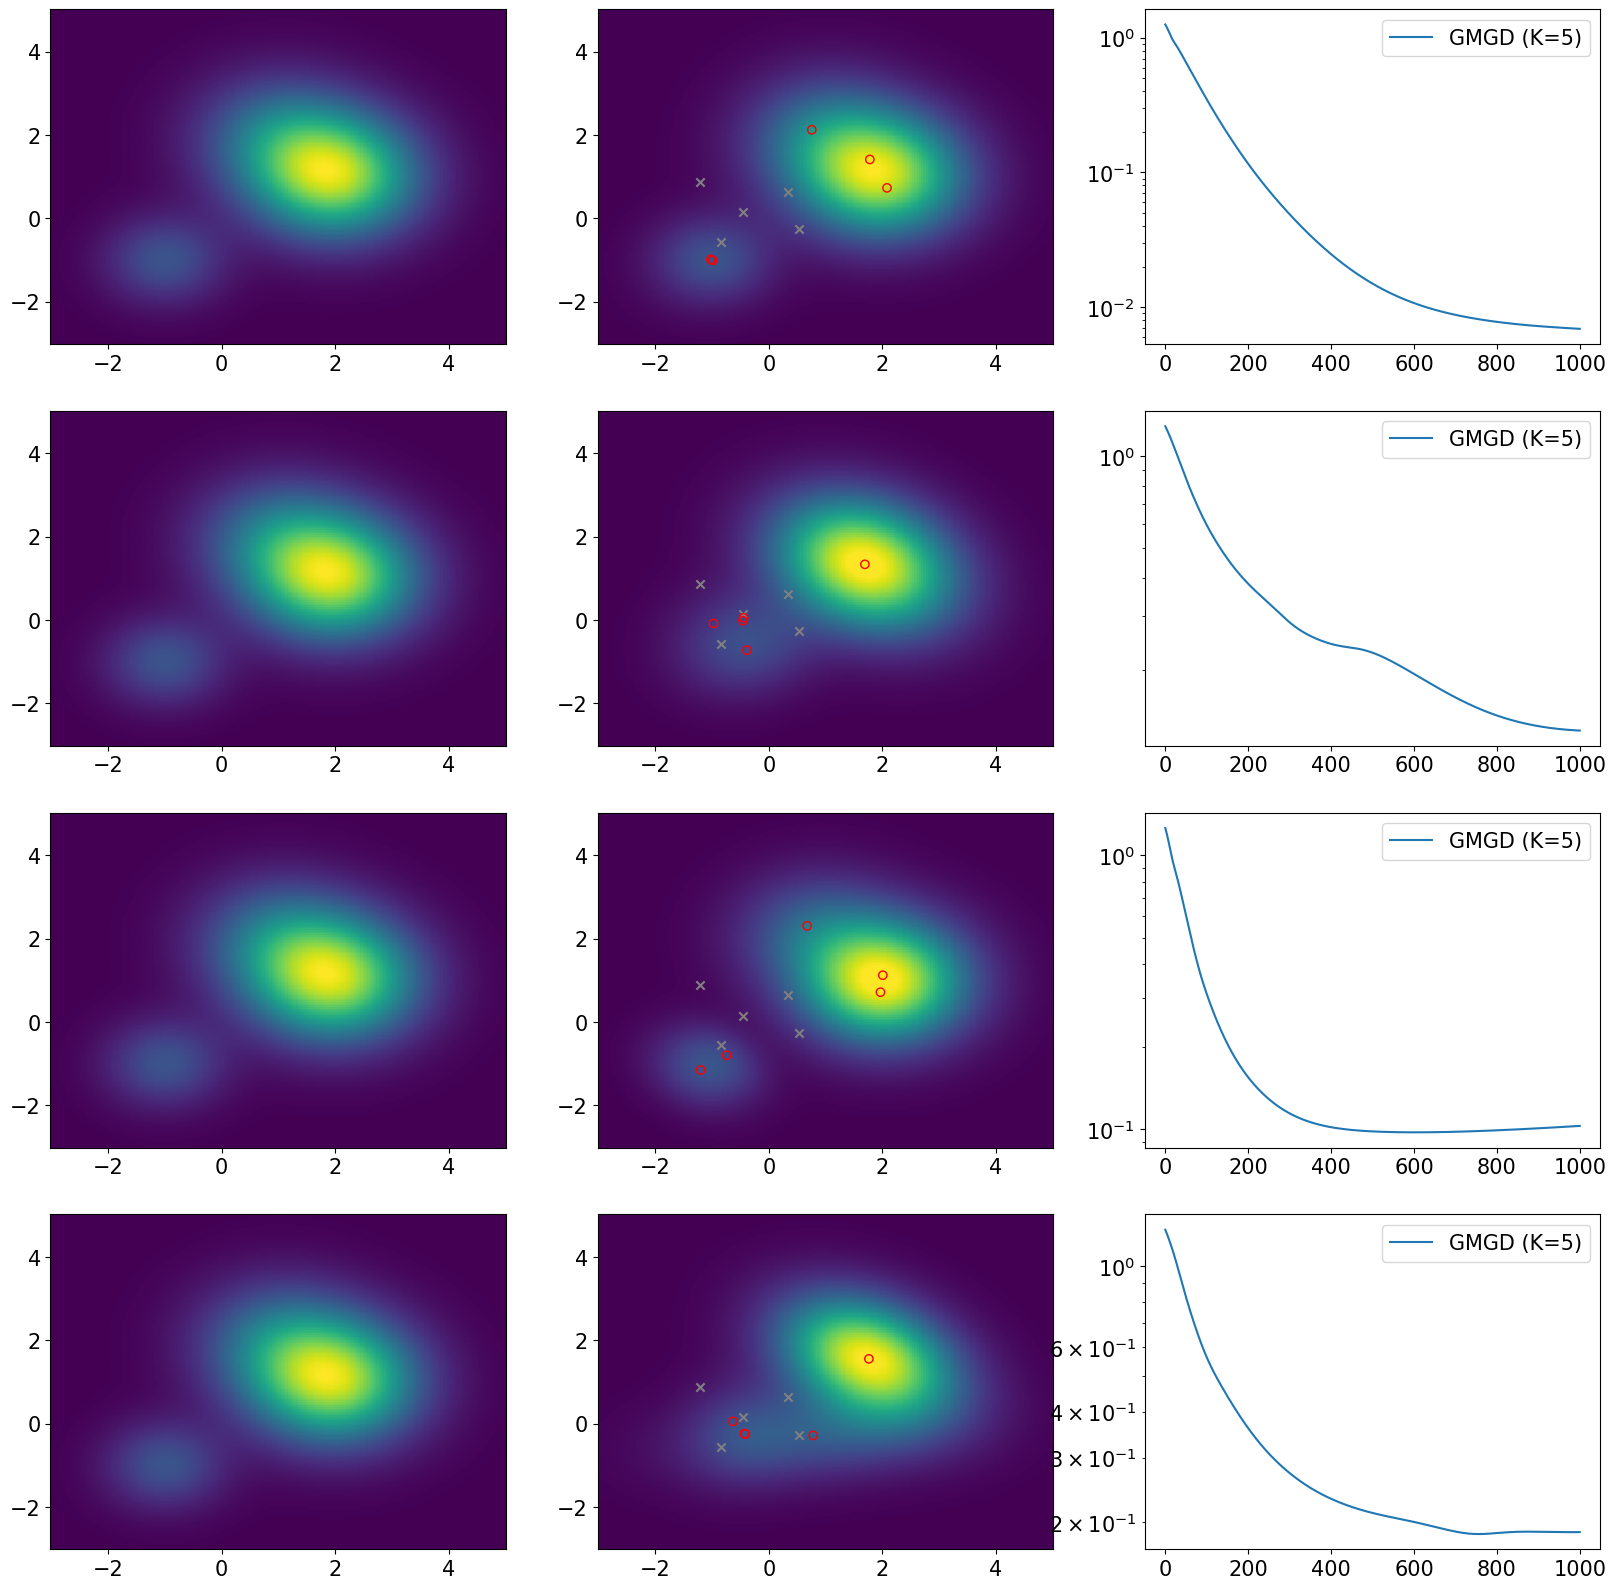

In [3]:
fig, ax = PyPlot.subplots(nrows=4, ncols=3, sharex=false, sharey=false, figsize=(20,20))

x_w_ref, x_mean_ref = [0.2;0.5;0.3], [1.0 2.0; 2.0 1.0; -1.0 -1.0]
N_modes_ref, N_x = size(x_mean_ref)
xx_cov_ref = zeros(N_modes_ref, 2, 2)
for im = 1:N_modes_ref
    xx_cov_ref[im,:,:] += I
end
xx_cov_ref[N_modes_ref,:,:] /= 2.0

inv_sqrt_x_cov_ref = [compute_sqrt_matrix(xx_cov_ref[im,:,:]; type="Cholesky")[2] for im = 1:N_modes_ref]
func_args = (x_w_ref, x_mean_ref, inv_sqrt_x_cov_ref)
func_dV(x) = Gaussian_mixture_V(x, func_args)
func_V(x) = -Gaussian_mixture(x, func_args)



Random.seed!(111);
N_modes = 5
x0_w  = ones(N_modes)/N_modes
μ0, Σ0 = [0.0; 0.0], [1.0 0.0; 0.0 1.0]
N_x = length(μ0)
x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
for im = 1:N_modes
    x0_mean[im, :]    .= rand(MvNormal(zeros(N_x), Σ0)) + μ0
    xx0_cov[im, :, :] .= Σ0
end


sqrt_matrix_type = "Cholesky"
N_iter , dt  = 1000, 0.01
T =  N_iter * dt
quadrature_test_list = [
    ("mean_point","mean_point"),
    ("cubature_transform_o3","cubature_transform_o3"),
    ("cubature_transform_o5","mean_point"),
    ("cubature_transform_o5","cubature_transform_o3")]
for iobs = 1:length(quadrature_test_list)
    quadrature_type_GM, quadrature_type = quadrature_test_list[iobs]
    gmgdobj = GMGD_Run(
            func_dV, 
            T,
            N_iter,
            # Initial condition
            x0_w, x0_mean, xx0_cov;
            sqrt_matrix_type = sqrt_matrix_type,
            # setup for Gaussian mixture part
            quadrature_type_GM = quadrature_type_GM,
            # setup for potential function part
            Bayesian_inverse_problem = false, 
            quadrature_type = quadrature_type)

    # Gaussian mixture test
    visualization_2d(ax[iobs,:]; Nx = 200, Ny = 200, x_lim=[-3.0, 5.0], y_lim=[-3.0, 5.0], func_V = func_V, objs=(gmgdobj,))

end


## Gaussian likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
A \theta
+\eta \quad (A = I)
\qquad 
y = 
\begin{bmatrix}
0.0\\
1.0
\end{bmatrix} 
\qquad
\Sigma_{\eta} = 
\sigma_\eta^2 I 
\end{align*} (\sigma_\eta = 0.3)
$$


We focus on the noninformative uniform prior, and hence we are sampling $e^{-\frac{1}{2}F^TF}$ with 

$$F(\theta) = \frac{y - A \theta}{\sigma_\eta}$$

     

## Circle shape likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
\theta^T A \theta
+\eta \quad (A = I)
\qquad 
y = 1
\qquad
\Sigma_{\eta} = 
\begin{bmatrix}
\sigma_\eta^2 
\end{bmatrix} 
\end{align*} (\sigma_\eta = 0.3)
$$


We focus on the noninformative uniform prior, and hence we are sampling $e^{-\frac{1}{2}F^TF}$ with 

$$F(\theta) = \frac{y - \theta^T A \theta}{\sigma_\eta}$$

     
     
## Banana shape likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
\begin{bmatrix}
\lambda(\theta_{(2)} -  \theta_{(1)}^2)\\
\theta_{(1)}
\end{bmatrix}
+\eta \quad (\lambda = 100)
\qquad 
y = 
\begin{bmatrix}
0\\
1
\end{bmatrix}
\qquad
\Sigma_{\eta} = 
\sigma_\eta^2 I \qquad (\sigma_\eta = 0.3)
\end{align*}
$$

We focus on the noninformative uniform prior, and hence we are sampling $e^{-\frac{1}{2}F^TF}$ with 
$$F(\theta) = 
\begin{bmatrix}
\frac{y_{(1)} - \lambda(\theta_{(2)} -  \theta_{(1)}^2)}{\sigma_\eta}\\
\frac{y_{(2)} - \theta_{(1)}}{\sigma_\eta}
\end{bmatrix}$$
     
     
## Double banana shape likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
\begin{bmatrix}
\log\Bigl(
\lambda(\theta_{(2)} -  \theta_{(1)}^2)^2 + (1 - \theta_{(1)})^2
\Bigr)\\ 
\theta_{(1)}\\ 
\theta_{(2)}
\end{bmatrix}
+ \eta \quad(\lambda = 100)
\qquad 
y = 
\begin{bmatrix}
\log(\lambda+1)\\
0\\
0
\end{bmatrix}
\qquad
\Sigma_{\eta} = 
\begin{bmatrix}
\sigma_\eta^2 & \\
& 1^2   \\
& & 1^2
\end{bmatrix}  
\end{align*}
$$

We essentially focus on the prior $\mathcal{N}(0,I)$, and we are sampling 
$e^{-\frac{1}{2}F^TF}$ 
with 
$$F(\theta) = 
\begin{bmatrix}
\frac{y_{(1)} - \log\Bigl(
\lambda(\theta_{(2)} -  \theta_{(1)}^2)^2 + (1 - \theta_{(1)})^2
\Bigr)}{\sigma_\eta}\\
y_{(2)} - \theta_{(1)}\\
y_{(3)} - \theta_{(2)}
\end{bmatrix}$$


## Gaussian mixture

This is not an inverse problem!

$$
e^{-\Phi_r(\theta)} \propto \sum_i w_i \mathcal{N}(\theta; m_i, C_i) \\
\Phi_r(\theta) = - \log\Bigl( \sum_i w_i \mathcal{N}(\theta; m_i, C_i) \Bigr)
$$

In [37]:
function G(θ, arg, Gtype = "Gaussian")
    if Gtype == "Gaussian"
        A = arg
        return A*θ
    elseif Gtype == "Double_modes"
        return [(θ[1]- θ[2])^2 ; (θ[1] + θ[2])^2]
        
    elseif Gtype == "Circle"
        A = arg
        return [θ'A*θ]
    elseif Gtype == "Banana"
        λ = arg
        return [λ*(θ[2] - θ[1]^2); θ[1]]
    elseif Gtype == "Double_banana"
        λ = arg
        return [log( λ*(θ[2] - θ[1]^2)^2 + (1 - θ[1])^2 ); θ[1]; θ[2]]
    else
        print("Error in function G")
    end
end


function F(θ, args)
    y, ση, arg, Gtype = args
    Gθ = G(θ, arg, Gtype )
    return (y - Gθ) ./ ση
end

function info_F(Gtype)
    if Gtype == "Gaussian"
        N_θ, N_f = 2, 2
    elseif Gtype == "Double_modes"
        N_θ, N_f = 2, 2
    elseif Gtype == "Circle"
        N_θ, N_f = 2, 1
    elseif Gtype == "Banana"
        N_θ, N_f = 2, 2
    elseif Gtype == "Double_banana"
        N_θ, N_f = 2, 3
    else
        print("Error in function G")
    end
    
    return N_θ, N_f
end


function logrho(θ, args)
    Fθ = F(θ, args)
    return -0.5*norm(Fθ)^2
end


function V(θ, args)
    return -logrho(θ, args), 
           -ForwardDiff.gradient(x -> logrho(x, args), θ), 
           -ForwardDiff.hessian(x -> logrho(x, args), θ)
end



V (generic function with 1 method)

In [38]:
function Gaussian_mixture_VI(func_V, func_F, w0, μ0, Σ0; N_iter = 100, dt = 1.0e-3)

    N_modes, N_θ = size(μ0)
    

    
    T =  N_iter * dt
    N_modes = 1
    x0_w = w0
    x0_mean = μ0
    xx0_cov = Σ0
    sqrt_matrix_type = "Cholesky"
    quadrature_type_GM = "cubature_transform_o5"
    
    objs = []

    if func_V !== nothing
#         gmgdobj = GMGD_Run(
#         func_V, 
#         T,
#         N_iter,
#         # Initial condition
#         x0_w, x0_mean, xx0_cov;
#         sqrt_matrix_type = sqrt_matrix_type,
#         # setup for Gaussian mixture part
#         quadrature_type_GM = quadrature_type_GM,
#         # setup for potential function part
#         Bayesian_inverse_problem = false, 
#         quadrature_type = "cubature_transform_o3")
        
        
        gmgdobj = GMGD_Run(
        func_V, 
        T,
        N_iter,
        # Initial condition
        x0_w, x0_mean, xx0_cov;
        sqrt_matrix_type = sqrt_matrix_type,
        # setup for Gaussian mixture part
        quadrature_type_GM = "mean_point",
        # setup for potential function part
        Bayesian_inverse_problem = false, 
        quadrature_type = "mean_point")
        
        push!(objs, gmgdobj)

    end

    if func_F !== nothing
        N_f = length(func_F(ones(N_θ)))
        gmgdobj_BIP = GMGD_Run(
        func_F, 
        T,
        N_iter,
        # Initial condition
        x0_w, x0_mean, xx0_cov;
        sqrt_matrix_type = sqrt_matrix_type,
        # setup for Gaussian mixture part
        quadrature_type_GM = "mean_point",
        # setup for potential function part
        Bayesian_inverse_problem = true, 
        N_f = N_f,
        quadrature_type = "unscented_transform",
        c_weight_BIP = 1.0e-3)
        
        push!(objs, gmgdobj_BIP)

    end

    return objs
end




Gaussian_mixture_VI (generic function with 1 method)

[ Info: ("iter = ", 100, " / ", 1000)
[ Info: ("iter = ", 200, " / ", 1000)
[ Info: ("iter = ", 300, " / ", 1000)
[ Info: ("iter = ", 400, " / ", 1000)
[ Info: ("iter = ", 500, " / ", 1000)
[ Info: ("iter = ", 600, " / ", 1000)
[ Info: ("iter = ", 700, " / ", 1000)
[ Info: ("iter = ", 800, " / ", 1000)
[ Info: ("iter = ", 900, " / ", 1000)
[ Info: ("iter = ", 1000, " / ", 1000)
[ Info: ("iter = ", 100, " / ", 1000)
[ Info: ("iter = ", 200, " / ", 1000)
[ Info: ("iter = ", 300, " / ", 1000)
[ Info: ("iter = ", 400, " / ", 1000)
[ Info: ("iter = ", 500, " / ", 1000)
[ Info: ("iter = ", 600, " / ", 1000)
[ Info: ("iter = ", 700, " / ", 1000)
[ Info: ("iter = ", 800, " / ", 1000)
[ Info: ("iter = ", 900, " / ", 1000)
[ Info: ("iter = ", 1000, " / ", 1000)
[ Info: ("iter = ", 100, " / ", 1000)
[ Info: ("iter = ", 200, " / ", 1000)
[ Info: ("iter = ", 300, " / ", 1000)
[ Info: ("iter = ", 400, " / ", 1000)
[ Info: ("iter = ", 500, " / ", 1000)
[ Info: ("iter = ", 600, " / ", 1000)
[ Info: ("

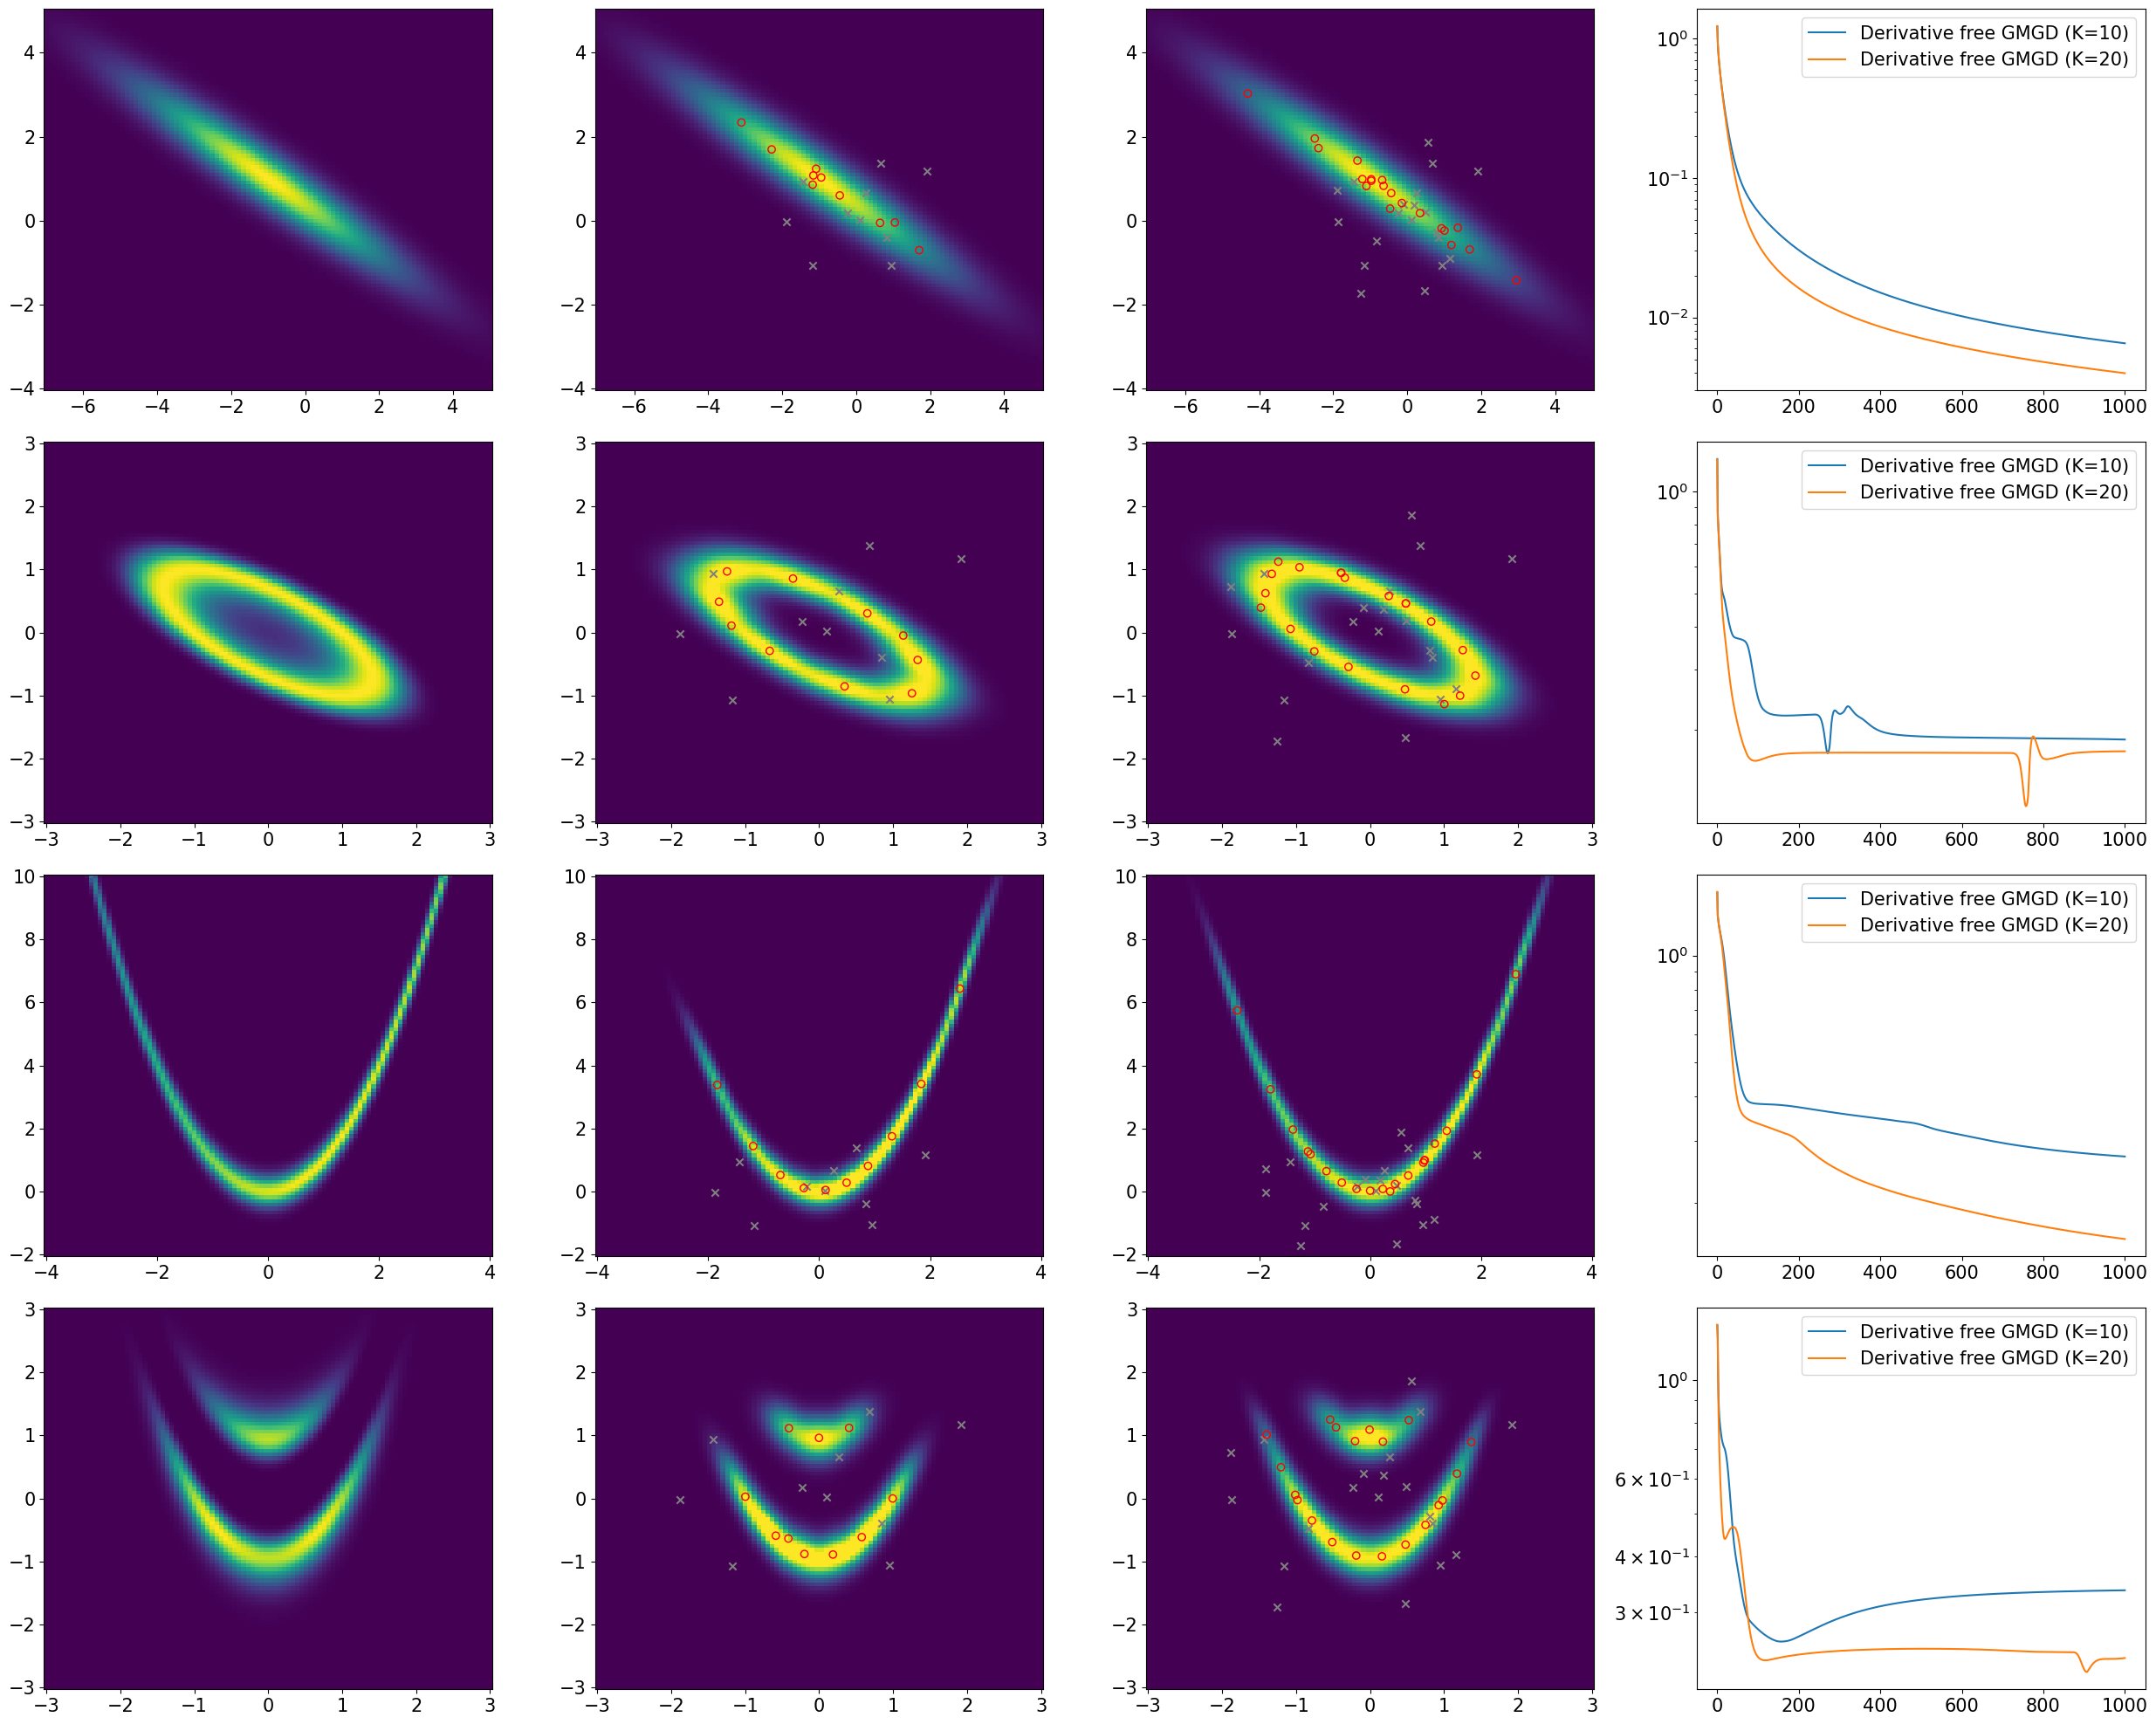

In [74]:
include("../Inversion/GMGD.jl")
fig, ax = PyPlot.subplots(nrows=4, ncols=4, sharex=false, sharey=false, figsize=(25,20))

    
Random.seed!(11);
#Random.seed!(111);
N_modes = 20
x0_w  = ones(N_modes)/N_modes
μ0, Σ0 = [0.0; 0.0], [1.0 0.0; 0.0 1.0]
N_x = length(μ0)
x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
for im = 1:N_modes
    x0_mean[im, :]    .= rand(MvNormal(zeros(N_x), Σ0)) + μ0
    xx0_cov[im, :, :] .= Σ0
end




N_iter = 1000
Nx, Ny = 100,100
ση = 1.0
Gtype = "Gaussian"
A = [1.0 1.0; 1.0 2.0]
y = [0.0; 1.0]
func_args = (y, ση, A , Gtype)
func_F(x) = F(x, func_args)
func_dV(x) = V(x, func_args)
objs = (Gaussian_mixture_VI(nothing, func_F, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = 1e-1)[1],
        Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = 1e-1)[1])
visualization_2d(ax[1,:]; Nx = Nx, Ny = Ny, x_lim=[-7.0, 5.0], y_lim=[-4.0, 5.0], func_F=func_F, objs=objs)


# N_iter = 1000
# Nx, Ny = 100,100
# ση = 0.1
# Gtype = "Double_modes"
# y = [0.0; 1.0]
# func_args = (y, ση, 0, Gtype)
# func_F(x) = F(x, func_args)
# func_dV(x) = V(x, func_args)
# objs = (Gaussian_mixture_VI(nothing, func_F, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = 1e-1)[1],
#         Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = 1e-1)[1])
# visualization_2d(ax[1,:]; Nx = Nx, Ny = Ny, x_lim=[-1.0, 1.0], y_lim=[-1.5, 1.5], func_F=func_F, objs=objs)



ση = 0.5
Gtype = "Circle"
A = [1.0 1.0; 1.0 2.0]
y = [1.0;]
func_args = (y, ση, A , Gtype)
func_F(x) = F(x, func_args)
func_dV(x) = V(x, func_args)
μ0, Σ0 = [0.0; 0.0], [1.0 0.0; 0.0 1.0]
objs = (Gaussian_mixture_VI(nothing, func_F, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = 1e-1)[1],
        Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = 1e-1)[1])
visualization_2d(ax[2,:]; Nx = Nx, Ny = Ny, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_F=func_F, objs=objs)



ση = sqrt(10.0)
Gtype = "Banana"
λ = 10.0
y = [0.0; 1.0]
func_args = (y, ση, λ , Gtype)
func_F(x) = F(x, func_args)
func_dV(x) = V(x, func_args)
μ0, Σ0 = [0.0; 0.0], [1.0 0.0; 0.0 1.0]
objs = (Gaussian_mixture_VI(nothing, func_F, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = 1e-1)[1],
        Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = 1e-1)[1])
visualization_2d(ax[3,:]; Nx = Nx, Ny = Ny, x_lim=[-4.0, 4.0], y_lim=[-2.0, 10.0], func_F=func_F, objs=objs)



ση = [0.5; 1.0; 1.0]
Gtype = "Double_banana"
λ = 100.0
y = [log(λ+1); 0.0; 0.0]
func_args = (y, ση, λ , Gtype)
func_F(x) = F(x, func_args)
func_dV(x) = V(x, func_args)
objs = (Gaussian_mixture_VI(nothing, func_F, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = 1e-1)[1],
        Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = 1e-1)[1])
visualization_2d(ax[4,:]; Nx = Nx, Ny = Ny, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_F=func_F, objs=objs)

fig.tight_layout()
fig.savefig("DFGMGD.pdf")

[ Info: 3.816105733943252e-16
[ Info: 2.5989654674417885e-15
[ Info: 1.4155234718157695e-14
[ Info: 3.4933763329720224e-14
[ Info: 3.68138973102509e-14
[ Info: 6.153480596427404e-15
[ Info: 5.011719387818616e-14
[ Info: 3.375077994860476e-14
[ Info: 6.646518689688358e-15
[ Info: 3.102273850532274e-14
[ Info: 0.0
[ Info: 2.0753747956710674e-14
[ Info: 3.552713678800501e-15
[ Info: 2.847716647714797e-14
[ Info: 3.4809342861069267e-14
[ Info: 2.0097183471152322e-14
[ Info: 2.869792300935272e-14
[ Info: 2.929642751054232e-14
[ Info: 1.020439314654103e-14
[ Info: 1.5485919901226002e-14
[ Info: 7.944109290391274e-15
[ Info: 3.7682219008410606e-15
[ Info: 6.101986129649244e-14
[ Info: 7.176679489978625e-14
[ Info: 4.6593403086362175e-14
[ Info: 9.045476940964657e-14
[ Info: 4.278033777464534e-14
[ Info: 1.4210854715202004e-14
[ Info: 0.0
[ Info: 6.153480596427404e-15
[ Info: 8.881784197001252e-15
[ Info: 8.881784197001252e-16
[ Info: 7.944109290391274e-15
[ Info: 0.0
[ Info: 3.552713678800501

[ Info: 5.043883840194739e-15
[ Info: 6.153480596427404e-15
[ Info: 2.5510982866352577e-15
[ Info: 1.7763568394002505e-15
[ Info: 8.140289677804162e-15
[ Info: 0.0
[ Info: 5.0242958677880805e-15
[ Info: 1.517719948885615e-14
[ Info: 7.944109290391274e-15
[ Info: 1.246617817651181e-14
[ Info: 3.552713678800501e-15
[ Info: 1.6280579355608324e-14
[ Info: 7.105427357601002e-15
[ Info: 1.4762209355896038e-14
[ Info: 3.76822190084106e-15
[ Info: 7.350984424391015e-15
[ Info: 5.0242958677880805e-15
[ Info: 8.702335715267317e-15
[ Info: 7.391117485641469e-15
[ Info: 6.4047456679787536e-15
[ Info: 8.152394204457378e-15
[ Info: 3.552713678800501e-15
[ Info: 6.280369834735101e-16
[ Info: 0.0
[ Info: 7.105427357601002e-15
[ Info: 5.17892563931115e-15
[ Info: 3.552713678800501e-15
[ Info: 1.3535617652607509e-14
[ Info: 5.0242958677880805e-15
[ Info: 0.0
[ Info: 5.329070518200751e-15
[ Info: 3.552713678800501e-15
[ Info: 5.347542221830668e-15
[ Info: 1.0658141036401503e-14
[ Info: 3.66205343881779e-

[ Info: 3.5596458096434965e-15
[ Info: 3.1401849173675503e-16
[ Info: 5.043883840194739e-15
[ Info: 3.5596458096434965e-15
[ Info: 1.0051044705644574e-14
[ Info: 7.94721185223203e-15
[ Info: 1.1787201827917035e-14
[ Info: 5.347542221830668e-15
[ Info: 1.2308964116001419e-14
[ Info: 1.5888218580782548e-14
[ Info: 1.151639004594246e-14
[ Info: 1.0209223628774433e-14
[ Info: 0.0
[ Info: 3.9968028886505635e-15
[ Info: 7.112362866677808e-15
[ Info: 6.173478961128007e-15
[ Info: 5.0242958677880805e-15
[ Info: 1.0658141036401503e-14
[ Info: 1.1783018260144474e-14
[ Info: 0.0
[ Info: 8.331852114593072e-15
[ Info: 1.178511022967008e-14
[ Info: 7.944109290391274e-15
[ Info: 8.705168045924987e-15
[ Info: 1.4762209355896038e-14
[ Info: 6.4047456679787536e-15
[ Info: 1.0688167281499563e-14
[ Info: 3.978256139440565e-15
[ Info: 2.5219419200973697e-15
[ Info: 6.4124390589420215e-15
[ Info: 3.552713678800501e-15
[ Info: 6.157485465446498e-15
[ Info: 6.173478961128007e-15
[ Info: 1.3761392409913291e-14

[ Info: 7.160723346098895e-15
[ Info: 6.158486275768499e-15
[ Info: 7.951088352073423e-15
[ Info: 5.5132383182932615e-15
[ Info: 8.616932905850419e-15
[ Info: 1.6283985928483748e-14
[ Info: 8.720022688750247e-15
[ Info: 3.5665644669189445e-15
[ Info: 8.70587598461163e-15
[ Info: 9.400252514501799e-15
[ Info: 9.106536260365895e-15
[ Info: 1.5203165631859585e-14
[ Info: 9.4061512267874e-15
[ Info: 8.98389288479247e-15
[ Info: 6.78690513370569e-15
[ Info: 8.147100686953716e-15
[ Info: 2.8108601893111292e-15
[ Info: 1.51792296933262e-14
[ Info: 7.951088352073423e-15
[ Info: 6.1704833383259285e-15
[ Info: 7.108895957933346e-15
[ Info: 6.298008605157983e-15
[ Info: 5.339468714465245e-15
[ Info: 1.3528330643921842e-14
[ Info: 1.0360231026219151e-14
[ Info: 5.0292000132872715e-15
[ Info: 6.4898210120014545e-15
[ Info: 7.113229329843195e-15
[ Info: 7.113229329843195e-15
[ Info: 6.1624878917045565e-15
[ Info: 6.4047456679787536e-15
[ Info: 7.176198573685038e-15
[ Info: 6.217248937900877e-15
[ In

[ Info: 6.165987175315851e-15
[ Info: 5.617333549722722e-15
[ Info: 8.702335715267317e-15
[ Info: 1.0070111465112378e-14
[ Info: 1.637720085286689e-14
[ Info: 8.702335715267317e-15
[ Info: 1.589408442438068e-14
[ Info: 8.888027007547732e-15
[ Info: 1.6527786915859712e-14
[ Info: 3.7142726579553426e-15
[ Info: 1.0698685361053582e-14
[ Info: ("iter = ", 700, " / ", 1000)
[ Info: 1.1949218545369531e-14
[ Info: 1.1234667099445444e-14
[ Info: 1.1816445329460086e-14
[ Info: 1.7406884408263417e-14
[ Info: 9.774731942158351e-15
[ Info: 8.042797661766892e-15
[ Info: 5.109740411221384e-15
[ Info: 9.404554024198152e-15
[ Info: 8.145020149535573e-15
[ Info: 8.042797661766892e-15
[ Info: 6.165987175315851e-15
[ Info: 1.2976822482155469e-14
[ Info: 9.409508563329438e-15
[ Info: 5.102196573270515e-15
[ Info: 3.552713678800501e-15
[ Info: 3.6771686055379495e-15
[ Info: 5.120433564739423e-15
[ Info: 8.331852114593072e-15
[ Info: 7.105427357601002e-15
[ Info: 1.0208167156103442e-14
[ Info: 8.04279766176

[ Info: 5.187917287970457e-15
[ Info: 5.111323202616102e-15
[ Info: 1.2812498018877737e-14
[ Info: 7.227356831213035e-15
[ Info: 3.672556682548643e-15
[ Info: 6.473240532069079e-15
[ Info: 5.0327410501256525e-15
[ Info: 9.615955123228963e-15
[ Info: 5.329070518200751e-15
[ Info: 7.222051976681913e-15
[ Info: 1.688821292607017e-14
[ Info: 8.75239631855103e-15
[ Info: 5.04281458966013e-15
[ Info: 8.75239631855103e-15
[ Info: 6.2803698347351005e-15
[ Info: 9.445962936647688e-15
[ Info: 3.982731677500722e-15
[ Info: 5.102196573270515e-15
[ Info: 1.609087455465323e-14
[ Info: 1.3293037379376718e-14
[ Info: 1.8258127343021428e-15
[ Info: 8.374483181240705e-15
[ Info: 7.949453184227732e-15
[ Info: 5.624888418394444e-15
[ Info: 1.0126792072454708e-14
[ Info: 2.2767664531979387e-14
[ Info: 1.4210854715202004e-14
[ Info: 1.507288760336424e-14
[ Info: 1.1273138114046079e-14
[ Info: 7.944109290391274e-15
[ Info: 3.564646966262391e-15
[ Info: 9.057678187205881e-15
[ Info: 4.351167857633658e-15
[ In

[ Info: 5.698894933927898e-14
[ Info: 5.934866419568193e-14
[ Info: 3.552713678800501e-15
[ Info: 1.2249136466422295e-13
[ Info: 5.0242958677880805e-15
[ Info: 9.493542985708791e-15
[ Info: 8.55802655949266e-14
[ Info: 1.1518359223098262e-13
[ Info: 6.466036496704424e-15
[ Info: 5.0242958677880805e-15
[ Info: 1.6304788408914756e-14
[ Info: 1.1982181969500553e-14
[ Info: 1.9479273482635503e-14
[ Info: 2.705666128784368e-14
[ Info: 5.786807878842355e-14
[ Info: 5.806540716222185e-14
[ Info: 2.9537775156135897e-14
[ Info: 9.397078787072079e-14
[ Info: 6.127787454580989e-14
[ Info: 6.434238129413513e-14
[ Info: 1.6663704229186144e-14
[ Info: 1.1432515868414236e-13
[ Info: 6.450309782763865e-14
[ Info: 5.864668402189173e-14
[ Info: 9.294098618031809e-15
[ Info: 1.5280799322856756e-14
[ Info: 5.3579045697976356e-15
[ Info: 4.0194366942304644e-14
[ Info: 6.656006943897521e-14
[ Info: 5.772743379403467e-14
[ Info: 3.1480647453430564e-14
[ Info: 4.9674509675801784e-14
[ Info: 4.359827582527323e

[ Info: 1.3337471054414258e-14
[ Info: 1.628663499255034e-14
[ Info: 3.552713678800501e-15
[ Info: 1.3293037379376718e-14
[ Info: 1.0048591735576161e-14
[ Info: 1.013652469562605e-14
[ Info: 9.668506465255628e-15
[ Info: 1.0242973220427484e-14
[ Info: 6.169484474161015e-15
[ Info: 1.1374233532693354e-14
[ Info: 6.169484474161015e-15
[ Info: 1.381681363641722e-14
[ Info: 1.608559532353378e-14
[ Info: 7.160723346098895e-15
[ Info: ("iter = ", 200, " / ", 1000)
[ Info: 1.2817187035862264e-14
[ Info: 0.0
[ Info: 1.6280579355608324e-14
[ Info: 1.4661671005472934e-14
[ Info: 1.1783018260144473e-14
[ Info: 8.702335715267317e-15
[ Info: 1.37882369488729e-14
[ Info: 8.747542958250513e-15
[ Info: 1.1408858372399359e-14
[ Info: 3.66205343881779e-15
[ Info: 1.1426131445685257e-14
[ Info: 1.4661671005472934e-14
[ Info: 1.1269720748118957e-14
[ Info: 1.1949218545369531e-14
[ Info: 1.3293037379376716e-14
[ Info: 1.3759600911837627e-14
[ Info: 1.1816445329460086e-14
[ Info: 1.0950198975068616e-14
[ In

[ Info: 1.0048591735576161e-14
[ Info: 7.944109290391274e-15
[ Info: 1.5209650241082524e-14
[ Info: 3.552713678800501e-15
[ Info: 1.6425298462602925e-14
[ Info: 7.944109290391274e-15
[ Info: 9.39959687352353e-15
[ Info: 1.9131948672901813e-14
[ Info: 5.0242958677880805e-15
[ Info: 8.702335715267317e-15
[ Info: 1.1791383911365253e-14
[ Info: 1.318877665294371e-14
[ Info: 7.105427357601002e-15
[ Info: 1.233896894832203e-14
[ Info: 1.0695084443661336e-14
[ Info: 3.552713678800501e-15
[ Info: 1.0048591735576161e-14
[ Info: 1.0805156823142815e-14
[ Info: 1.0695084443661336e-14
[ Info: 1.1252207573981756e-14
[ Info: 1.356472654139408e-14
[ Info: 1.425934424581705e-14
[ Info: 1.591302455776226e-14
[ Info: 1.2314970930892997e-14
[ Info: 1.2817187035862264e-14
[ Info: 2.042810365310288e-14
[ Info: 9.441466109136565e-15
[ Info: 1.1243440757244517e-14
[ Info: 1.5612751830260183e-14
[ Info: 1.8115356374411762e-14
[ Info: 1.0658141036401503e-14
[ Info: 7.95651227888113e-15
[ Info: 1.287858708565181

[ Info: 7.944109290391274e-15
[ Info: 8.79251776862914e-15
[ Info: 6.3428626160647376e-15
[ Info: 1.0695084443661336e-14
[ Info: 7.944109290391274e-15
[ Info: 1.2306961192854808e-14
[ Info: 8.72496861620875e-15
[ Info: 7.944109290391274e-15
[ Info: 1.2809491335957507e-14
[ Info: 1.1269720748118957e-14
[ Info: 7.944109290391274e-15
[ Info: 1.330045330038837e-14
[ Info: 1.3293037379376718e-14
[ Info: 7.944109290391274e-15
[ Info: 1.0950198975068616e-14
[ Info: 1.2047838252593955e-14
[ Info: 7.993605777301127e-15
[ Info: 1.03578512786223e-14
[ Info: 3.66205343881779e-15
[ Info: 1.1269720748118957e-14
[ Info: 1.706135029904003e-14
[ Info: 6.2803698347351005e-15
[ Info: 1.8588197236063618e-14
[ Info: 1.0695084443661336e-14
[ Info: 1.2306961192854808e-14
[ Info: 1.3181297901759441e-14
[ Info: 1.0731900677991188e-14
[ Info: 7.270053689609713e-15
[ Info: 1.6280579355608327e-14
[ Info: 9.441466109136565e-15
[ Info: 1.1234667099445444e-14
[ Info: 9.41008164741723e-15
[ Info: 1.5517725069052932e-

[ Info: 1.3324526538729397e-14
[ Info: 1.178511022967008e-14
[ Info: 9.42055475210265e-15
[ Info: 8.215650382226158e-15
[ Info: 1.4245506936157285e-14
[ Info: 8.79251776862914e-15
[ Info: 5.65669253787293e-15
[ Info: 1.5232324633756008e-14
[ Info: 7.160723346098895e-15
[ Info: 1.0068198762484779e-14
[ Info: 1.717942333624185e-14
[ Info: 5.17892563931115e-15
[ Info: 1.1868486651150049e-14
[ Info: 1.3775716007243676e-14
[ Info: 1.4210854715202004e-14
[ Info: 8.747542958250513e-15
[ Info: 8.11906333221578e-15
[ Info: 9.53499970250244e-15
[ Info: 9.423171209520718e-15
[ Info: 1.634103474132873e-14
[ Info: 1.1254398211123894e-14
[ Info: 1.1374233532693354e-14
[ Info: 7.993605777301127e-15
[ Info: 8.837263695108354e-15
[ Info: 6.3428626160647376e-15
[ Info: 1.3759600911837627e-14
[ Info: 1.5485919901226002e-14
[ Info: 1.436613150185001e-14
[ Info: 6.296051182078799e-15
[ Info: 1.1858096658218189e-14
[ Info: 1.130466570252318e-14
[ Info: 1.0165666657133341e-14
[ Info: 9.709216146214426e-15
[ 

[ Info: 9.198115681211752e-15
[ Info: 1.4376423657081935e-14
[ Info: 9.765230406621845e-15
[ Info: 1.1953601734790137e-14
[ Info: 9.39959687352353e-15
[ Info: 6.296051182078799e-15
[ Info: 1.0329251542640534e-14
[ Info: 1.0623534945633305e-14
[ Info: 6.466036496704424e-15
[ Info: 1.6687357476335705e-14
[ Info: ("iter = ", 1000, " / ", 1000)
[ Info: 2.589462819655575e-15


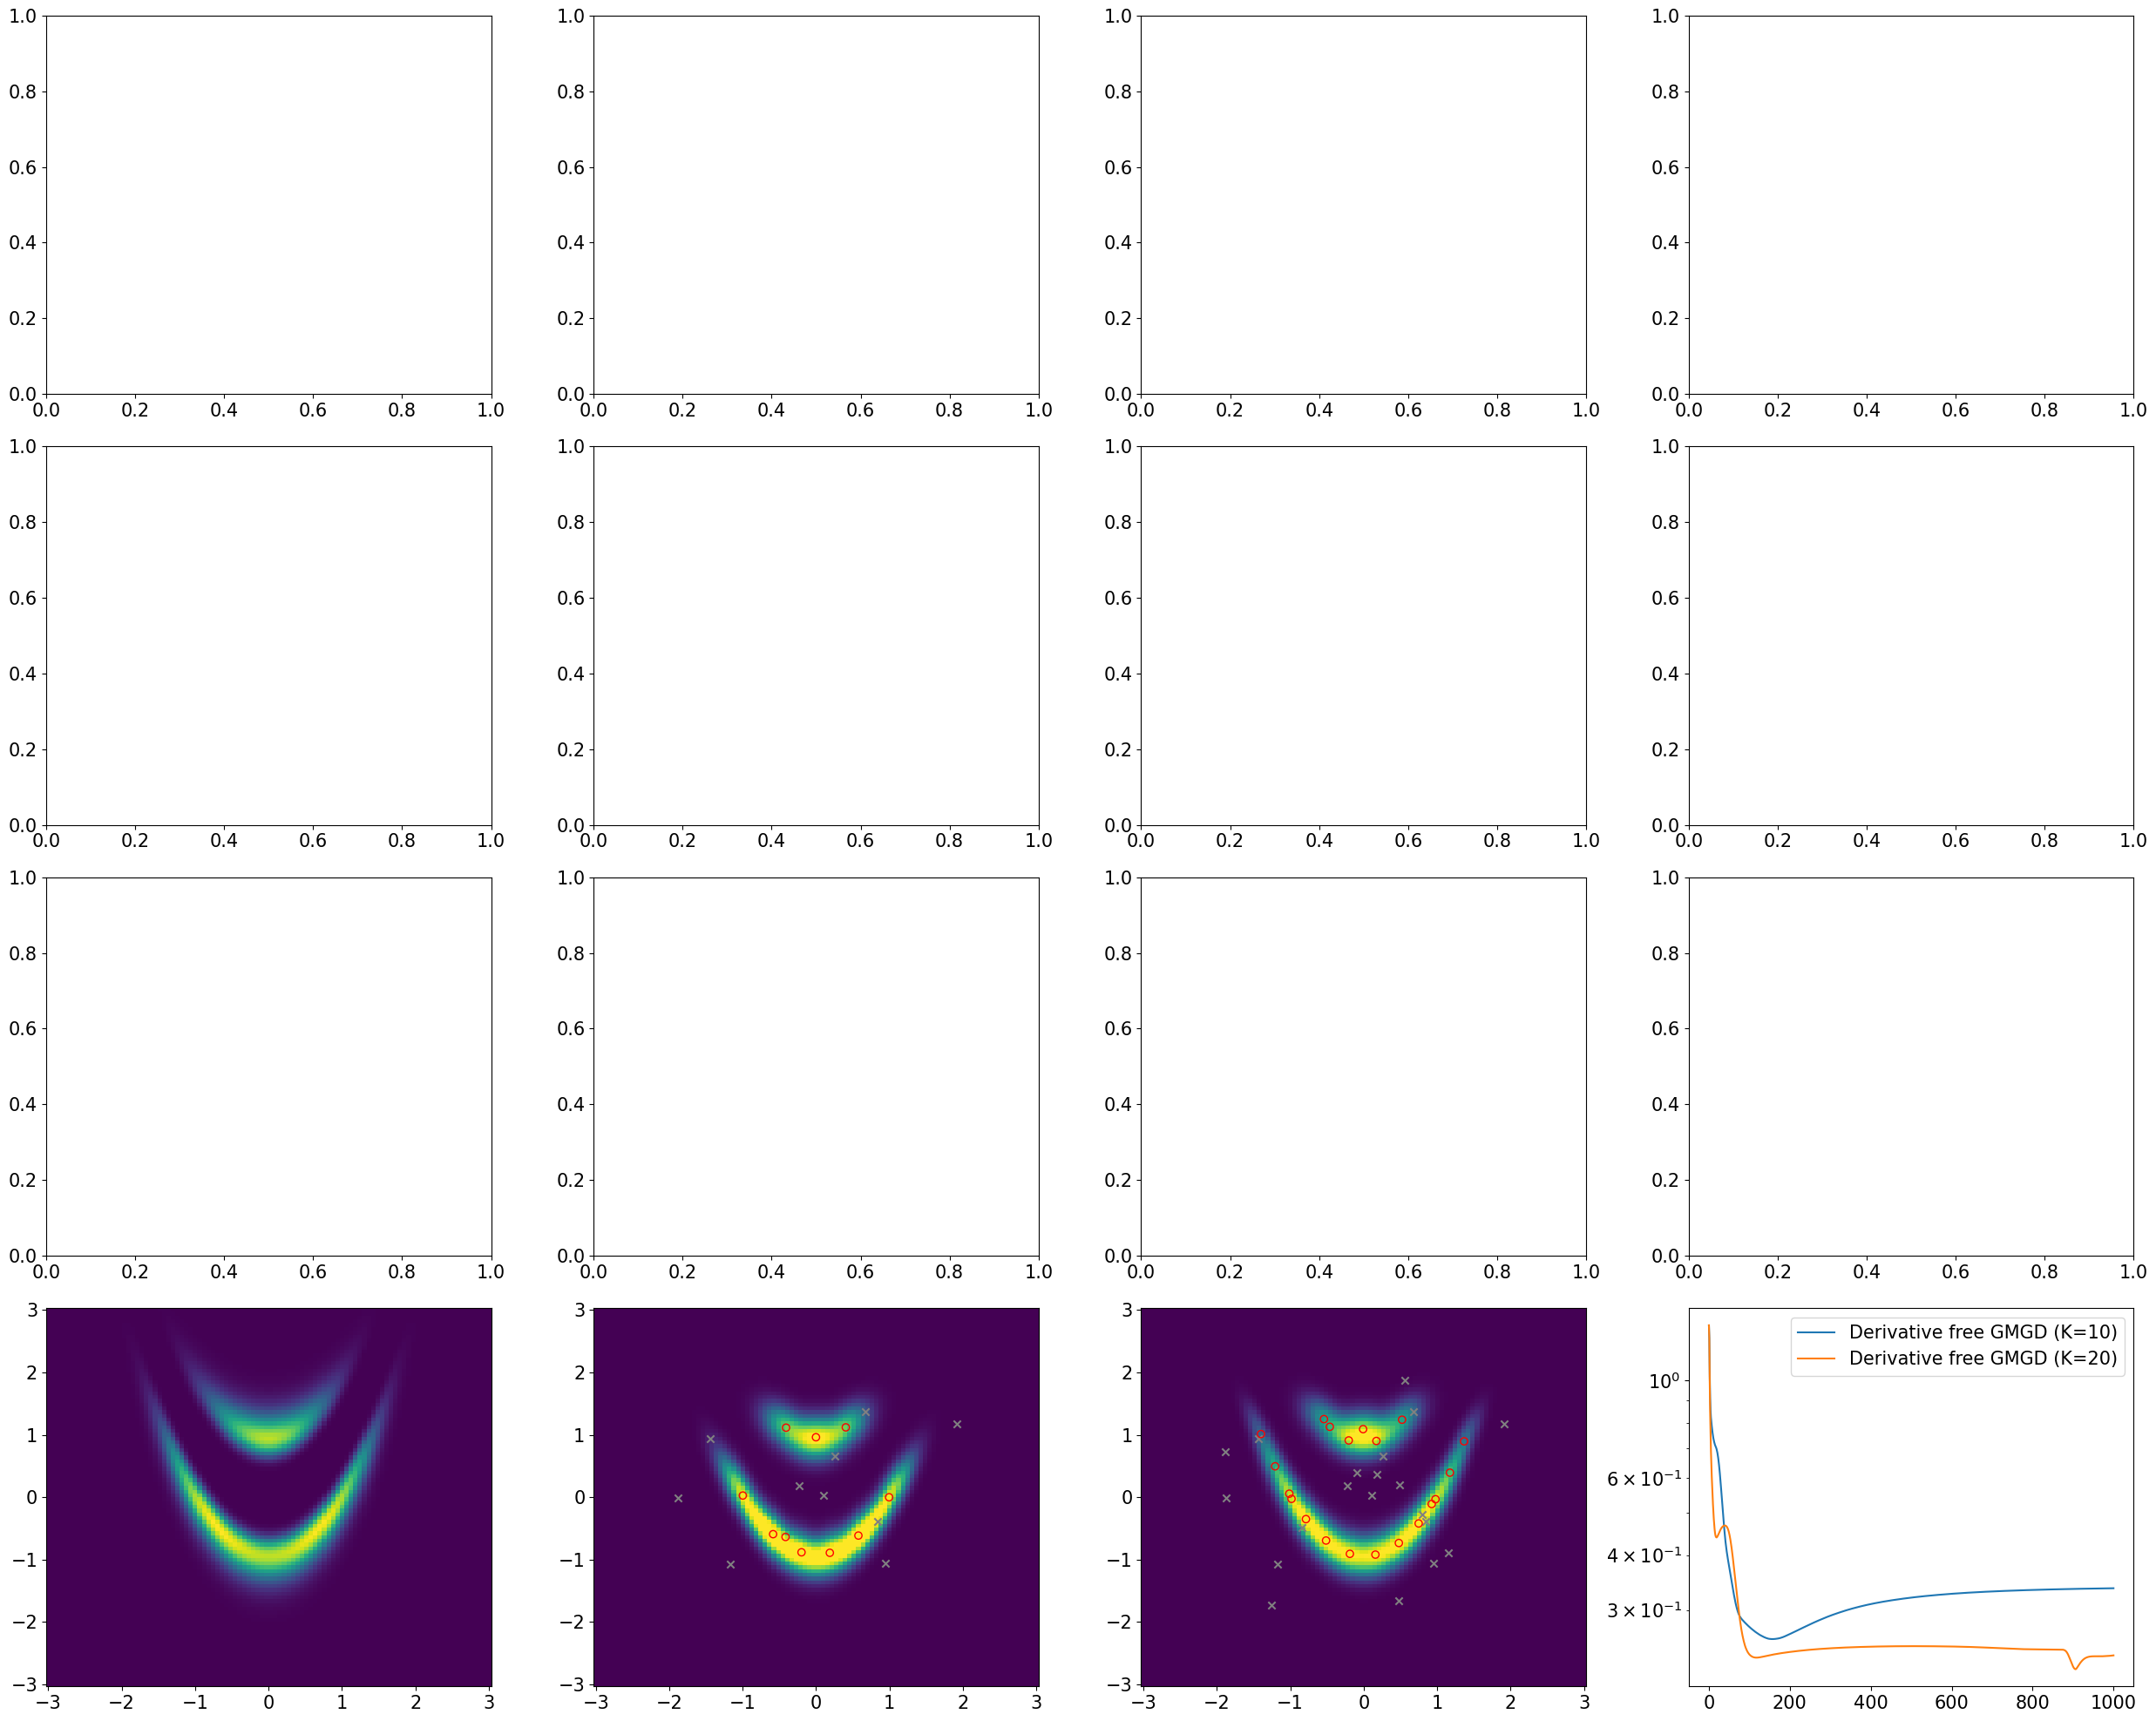

In [83]:
include("../Inversion/GMGD.jl")
fig, ax = PyPlot.subplots(nrows=4, ncols=4, sharex=false, sharey=false, figsize=(25,20))

    
Random.seed!(11);
#Random.seed!(111);
N_modes = 20
x0_w  = ones(N_modes)/N_modes
μ0, Σ0 = [0.0; 0.0], [1.0 0.0; 0.0 1.0]
N_x = length(μ0)
x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
for im = 1:N_modes
    x0_mean[im, :]    .= rand(MvNormal(zeros(N_x), Σ0)) + μ0
    xx0_cov[im, :, :] .= Σ0
end




# N_iter = 1000
# Nx, Ny = 100,100
# ση = 1.0
# Gtype = "Gaussian"
# A = [1.0 1.0; 1.0 2.0]
# y = [0.0; 1.0]
# func_args = (y, ση, A , Gtype)
# func_F(x) = F(x, func_args)
# func_dV(x) = V(x, func_args)
# objs = (Gaussian_mixture_VI(nothing, func_F, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = 1e-1)[1],
#         Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = 1e-1)[1])
# visualization_2d(ax[1,:]; Nx = Nx, Ny = Ny, x_lim=[-7.0, 5.0], y_lim=[-4.0, 5.0], func_F=func_F, objs=objs)


# N_iter = 1000
# Nx, Ny = 100,100
# ση = 0.1
# Gtype = "Double_modes"
# y = [0.0; 1.0]
# func_args = (y, ση, 0, Gtype)
# func_F(x) = F(x, func_args)
# func_dV(x) = V(x, func_args)
# objs = (Gaussian_mixture_VI(nothing, func_F, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = 1e-1)[1],
#         Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = 1e-1)[1])
# visualization_2d(ax[1,:]; Nx = Nx, Ny = Ny, x_lim=[-1.0, 1.0], y_lim=[-1.5, 1.5], func_F=func_F, objs=objs)



# ση = 0.5
# Gtype = "Circle"
# A = [1.0 1.0; 1.0 2.0]
# y = [1.0;]
# func_args = (y, ση, A , Gtype)
# func_F(x) = F(x, func_args)
# func_dV(x) = V(x, func_args)
# μ0, Σ0 = [0.0; 0.0], [1.0 0.0; 0.0 1.0]
# objs = (Gaussian_mixture_VI(nothing, func_F, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = 1e-1)[1],
#         Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = 1e-1)[1])
# visualization_2d(ax[2,:]; Nx = Nx, Ny = Ny, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_F=func_F, objs=objs)



# ση = sqrt(10.0)
# Gtype = "Banana"
# λ = 10.0
# y = [0.0; 1.0]
# func_args = (y, ση, λ , Gtype)
# func_F(x) = F(x, func_args)
# func_dV(x) = V(x, func_args)
# μ0, Σ0 = [0.0; 0.0], [1.0 0.0; 0.0 1.0]
# objs = (Gaussian_mixture_VI(nothing, func_F, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = 1e-1)[1],
#         Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = 1e-1)[1])
# visualization_2d(ax[3,:]; Nx = Nx, Ny = Ny, x_lim=[-4.0, 4.0], y_lim=[-2.0, 10.0], func_F=func_F, objs=objs)



ση = [0.5; 1.0; 1.0]
Gtype = "Double_banana"
λ = 100.0
y = [log(λ+1); 0.0; 0.0]
func_args = (y, ση, λ , Gtype)
func_F(x) = F(x, func_args)
func_dV(x) = V(x, func_args)
objs = (Gaussian_mixture_VI(nothing, func_F, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = 1e-1)[1],
        Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = 1e-1)[1])
visualization_2d(ax[4,:]; Nx = Nx, Ny = Ny, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_F=func_F, objs=objs)

fig.tight_layout()
fig.savefig("DFGMGD.pdf")

In [56]:
for i = 1:20
    @info cov[i,:,:], inv(cov[i,:,:])
end

[ Info: ([0.03152670136151958 -0.020162617324459023; -0.020162617324459023 0.03722361685456116], [48.5310182250785 26.287406531767566; 26.287406531767566 41.10355327185338])
[ Info: ([0.041587805875870236 -0.03531356423077111; -0.03531356423077111 0.055690427224480074], [52.096066519137345 33.03436304732453; 33.03436304732453 38.90365381039746])
[ Info: ([0.018411404809631757 -0.0037176468746028587; -0.0037176468746028587 0.018792921958894548], [56.57396947203376 11.191556121587576; 11.191556121587576 55.425455174860566])
[ Info: ([0.02779301924518692 0.008221730797502207; 0.0082217307975022 0.02627814272224008], [39.65003497900747 -12.405439652059105; -12.405439652059094 41.93577137060125])
[ Info: ([0.038693762360427514 -0.0035814230562004087; -0.003581423056200407 0.03824222308044332], [26.069937306220897 2.4414761230224054; 2.441476123022404 26.377754158178544])
[ Info: ([0.04506757693889081 0.020577386549199935; 0.020577386549199935 0.04573022134620831], [27.926487225957075 -12.56